<a href="https://colab.research.google.com/github/geraldmc/torch-draft-final_project/blob/main/load_deepweeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to **[This Project ...](https://)**

This notebook is associated with the project submission of MOHAMMED RASHED and GERALD MCCOLLAM and for the class `EN.525.733.8VL.SP22 Deep Learning for Computer Vision`. Our semester project is [Weed Object Detection](https://).

<hr>

### Download the code from Github

In [1]:
import os

if os.path.isfile("../main.zip"):
  print ('Have already downloaded the project file, continuing...')
  print()
else:
  print ('Downloading file...')
  ! wget https://github.com/geraldmc/torch-draft-final_project/archive/refs/heads/main.zip
  ! unzip -qq main.zip
  %cd torch-draft-final_project-main

--2022-03-29 22:06:09--  https://github.com/geraldmc/torch-draft-final_project/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/geraldmc/torch-draft-final_project/zip/refs/heads/main [following]
--2022-03-29 22:06:09--  https://codeload.github.com/geraldmc/torch-draft-final_project/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.193.111.178
Connecting to codeload.github.com (codeload.github.com)|52.193.111.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ] 526.76K  2.65MB/s    in 0.2s    

2022-03-29 22:06:11 (2.65 MB/s) - ‘main.zip’ saved [539403]

/content/torch-draft-final_project-main


### Try and import the project.

In [ ]:
try:
  import conf.params as params
except ImportError:
  pass

### Download the dataset from Google Drive

The project dataset and models are available on the DeepWeeds Github. There are two options for getting these into our Colab Notebook environment (this uses the first).

* Download from Github as two zipped files ([dataset link here](https://drive.google.com/file/d/1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj), [models file link here](https://drive.google.com/file/d/1MRbN5hXOTYnw7-71K-2vjY01uJ9GkQM5)) and upload these to Google Drive, then mount Google Drive on Colab to access the uploaded dataset and models. 
* Use the [Drive API](https://) to download the dataset and models into the Colab Notebook. 

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')
print("Downloading DeepWeeds images to " + params.IMG_ZIP_FILE)
!cp '{params.GD_ZIP_IMG}' '{params.IMG_ZIP_FILE}'
print()
!ls -lart {params.IMG_ZIP_FILE}

Mounted at /content/gdrive

-rw------- 1 root root 491516047 Mar 29 22:07 /content/torch-draft-final_project-main/data/images.zip


### Unzip the data files into place.

In [ ]:
from zipfile import ZipFile

print("Unzipping DeepWeeds images into " + params.IMG_DIRECTORY)

with ZipFile(params.IMG_ZIP_FILE, "r") as zip_ref:
    zip_ref.extractall(params.IMG_DIRECTORY)

img_list=os.listdir(params.IMG_DIRECTORY)
print(len(img_list))

### We use a pre-trained Resnet-50 model. What is that?

### Imagenet-trained resnet50 model for Pytorch.

*Author: Pytorch Team*

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

Pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

### Get the Labels

In [7]:
LABEL_PATH = os.path.join(params.DATA_PATH, 'labels')
!ls {LABEL_PATH}

labels.csv	  test_subset3.csv   train_subset2.csv	val_subset1.csv
test_subset0.csv  test_subset4.csv   train_subset3.csv	val_subset2.csv
test_subset1.csv  train_subset0.csv  train_subset4.csv	val_subset3.csv
test_subset2.csv  train_subset1.csv  val_subset0.csv	val_subset4.csv


In [8]:
import pandas as pd
label_df = pd.read_csv(os.path.join(LABEL_PATH, 'labels.csv'))

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


### Note the unusual class distribution between weed and non-weed.

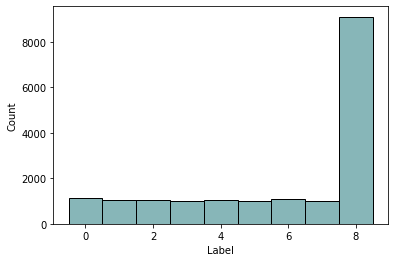

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(label_df['Label'], bins=8, discrete=True, color="cadetblue")
None

## To run k-folds on the data, as paper does, the following steps are required:

### 1) Combine all train, test, val files, and random sample from the combined dataframes.

In [ ]:
import glob 

joined_val = os.path.join("data/", "labels/", "val*.csv")
joined_train = os.path.join("data/", "labels/", "train*.csv")
joined_test = os.path.join("data/", "labels/", "test*.csv")

val_files = glob.glob(joined_val)
train_files = glob.glob(joined_train)
test_files = glob.glob(joined_test)

train_df = pd.concat(map(pd.read_csv, train_files), ignore_index=True)
val_df = pd.concat(map(pd.read_csv, val_files), ignore_index=True)
test_df = pd.concat(map(pd.read_csv, test_files), ignore_index=True)

# In the paper, each fold contains 10,505 samples from the total
def sample_data(train_sample_no, val_sample_no, test_sample_no): 
    train = train_df.sample(n=train_sample_no)
    val = val_df.sample(n=val_sample_no)
    test = test_df.sample(n=test_sample_no)
    return train, val, test

### 2) Copy files to their respective directories, for ImageFolder.

In [ ]:
import shutil

files = []
for dirpath, dirnames, filenames in os.walk(params.IMAGE_PATH):
    for file in filenames:
        files.append(file)

def copy_files(df, filepath):

  labels = dict(zip(df.Filename, df.Label)) 
  for f in files:
      try:
          src = os.path.join(params.IMG_DIRECTORY, f)
          dst = os.path.join(filepath, str(labels[f]), f)
          shutil.copyfile(src, dst)
      except KeyError:
          pass

# sample number same as paper.
sample_train_df = train_df.sample(n=10505)
sample_val_df = val_df.sample(n=3502)
sample_test_df = test_df.sample(n=3502) 

copy_files(sample_train_df, params.IMG_TRAIN_PATH)
copy_files(sample_val_df, params.IMG_VAL_PATH)
copy_files(label_df, params.IMG_CLASSES) # this holds all unsegregatd files.

### 3) Instantiate the data loaders for this k-fold.

In [ ]:
# Each training dataset contains 8382 x 5 images.

train_loader = DataLoader(
 ConcatDataset([ImageFolder(
          params.IMG_TRAIN_PATH, 
          transform=tsf.base_transform),
     ImageFolder(
          params.IMG_TRAIN_PATH,
          transform=tsf.data_translate),
     ImageFolder(
          params.IMG_TRAIN_PATH,
          transform=tsf.data_grayscale),
     ImageFolder(
          params.IMG_TRAIN_PATH,
          transform=tsf.data_rotate),
     ImageFolder(
          params.IMG_TRAIN_PATH,
          transform=tsf.data_jitter_hue)]), 
          batch_size=32, 
          shuffle=True, num_workers=2, 
          pin_memory=torch.cuda.is_available())

# Each validation dataset contains 3251 x 5 images.

val_loader = DataLoader(
 ConcatDataset([ImageFolder(
          params.IMG_VAL_PATH, 
          transform=tsf.base_transform),
     ImageFolder(
          params.IMG_VAL_PATH,
          transform=tsf.data_translate),
     ImageFolder(
          params.IMG_VAL_PATH,
          transform=tsf.data_grayscale),
     ImageFolder(
          params.IMG_VAL_PATH,
          transform=tsf.data_rotate),
     ImageFolder(
          params.IMG_VAL_PATH,
          transform=tsf.data_jitter_hue)]), 
          batch_size=32, 
          shuffle=False, num_workers=2, 
          pin_memory=torch.cuda.is_available())

dataloaders_augment = {}
dataloaders_augment['train'] = train_loader
dataloaders_augment['val'] = val_loader

### Function to Encapsulate Training and Reporting

In [ ]:
import time
import copy


def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    # lists to store per-epoch loss and accuracy values
    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(params.DEVICE)
                labels = labels.to(params.DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

### Functions to initialize and alter the ResNet50 model. 
#### Note the handling of grad vs. no-grad for a tunable model.

The function in the next cell `set_parameter_requires_grad` sets the `.requires_grad` attribute of the model parameters to False. By default, when a pretrained model is loaded all of the parameters have .requires_grad=True (appropriate when training a model from scratch). Here we want to compute gradients for the newly initialized fc layer only.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ Resnet50
        """
        model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### 4) Reinstatiate the model between each k-fold.

In [ ]:
num_classes = 9
feature_extract = True

resnet50_torch, input_size = initialize_model('resnet50', num_classes, 
                                        feature_extract, use_pretrained=True)
if torch.cuda.is_available():
    resnet50_torch.to('cuda') #IMPORTANT!

### 5) Set parameters to be optimized on each run.

In [ ]:
# Gather the parameters to be optimized/updated in this run. Only 
# parameters that we have just initialized, i.e. the parameters with 
# requires_grad is True, will be updated. (i.e. the last fc layer).
import torch.optim as optim

params_to_update = resnet50_torch.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet50_torch.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet50_torch.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer = optim.Adam(params_to_update, lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=16, factor=0.5, min_lr=0.000003125)

# From Deepweeds code...
# reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=LR_PATIENCE, min_lr=0.000003125)


## 6) Train the model.

In [ ]:
criterion = nn.CrossEntropyLoss() # same as DeepWeeds (i.e. binary_crossentropy)

params.NUM_EPOCHS = 10 # set this manually

resnet50_torch, val_acc, val_loss, train_acc, train_loss = train_model(
                                    resnet50_torch, dataloaders_dict, 
                                    criterion, optimizer, 
                                    num_epochs=params.NUM_EPOCHS)

### Print Stats

In [ ]:
# Convert tensor objects to lists
val_acc_record = [val_acc[x].item() for x in range(len(val_acc))]
val_loss_record = [val_loss[x] for x in range(len(val_loss))]
train_acc_record = [train_acc[x].item() for x in range(len(train_acc))]
train_loss_record = [train_loss[x] for x in range(len(train_loss))]

# Accuracy plots
plt.figure(figsize=(8, 6))
plt.plot(train_acc_record, color='green', label='train acc')
plt.plot(val_acc_record, color='blue', label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig(f"../outputs/{acc_plot_name}.png")
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(train_loss_record, color='orange', label='train loss')
plt.plot(val_loss_record, color='red', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"../outputs/{loss_plot_name}.png")
plt.show()

# Train acc versus loss
plt.figure(figsize=(8, 6))
plt.plot(train_acc_record, color='blue', label='train acc')
plt.plot(train_loss_record, color='green', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
#plt.savefig(f"../outputs/{acc_plot_name}.png")
plt.show()

# Val acc versus loss
plt.figure(figsize=(8, 6))
plt.plot(val_acc_record, color='red', label='val acc')
plt.plot(val_loss_record, color='orange', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
#plt.savefig(f"../outputs/{acc_plot_name}.png")
plt.show()

### 7) Delete files from their respective directories, start again on the next fold.

In [ ]:
import os

def delete_class_files(path):
  for file_name in os.listdir(path):
      file = path + file_name
      #print(file)
      if os.path.isfile(file):
          os.remove(file)

### Functions to checkpoint, print state[s] of model and optimizer, save and load an existing model.

In [ ]:
def checkpoint(epoch, nn, opt, LOSS, MODEL_PATH ):
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': nn.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, MODEL_PATH)

In [ ]:
def print_states(m, opt):
    # Print the model's state_dict
    print("Model's state_dict:")
    for param_tensor in m.state_dict():
        print(param_tensor, "\t", m.state_dict()[param_tensor].size())

    # Print optimizer's state_dict
    print("Optimizer's state_dict:")
    for var_name in opt.state_dict():
        print(var_name, "\t", opt.state_dict()[var_name])

In [ ]:
def save_model(m)
    torch.save(m.state_dict(), os.path.join(params.OUTPUT_PATH, 'model.pth'))

In [ ]:
def load_model():
    model.load_state_dict(torch.load(params.OUTPUT_PATH))
    return model

In [ ]:
from data import transforms as tsf
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder

train_data_na = ImageFolder(
    root=params.IMG_TRAIN_PATH, 
    transform=tsf.base_transform)
train_loader_na = DataLoader(train_data_na, 
    batch_size=32, shuffle=True, 
    num_workers=2)

val_data_na = ImageFolder(
    root=params.IMG_VAL_PATH, 
    transform=tsf.base_transform)
val_loader_na = DataLoader(val_data_na, 
    batch_size=32, shuffle=True, 
    num_workers=2)

In [ ]:
from utils.normalize import UnNormalize

labels_map = {
    0: 'Chinee Apple',
    1: 'Lantana',
    2: 'Parkinsonia',
    3: 'Parthenium',
    4: 'Prickly Acacia',
    5: 'Rubber Vine',
    6: 'Siam Weed',
    7: 'Snake Weed',
    8: 'Negatives',
}

unorm = UnNormalize(mean = [0.485, 0.456, 0.406], 
                    std = [0.229, 0.224, 0.225])

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    sample_idx = torch.randint(len(train_data_na), size=(1,)).item()
    img, label = train_data_na[sample_idx]
    img = unorm(img) # undo normalization
    img = img.permute(1, 2, 0).numpy() # format for imshow
    fig.add_subplot(rows, columns, i)
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.title(labels_map[label])
    plt.imshow(img)
plt.show()

In [ ]:
''' GUTTER ------ 
'''